# Run this code twice after the stage0 and stage0

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('waveglow/')

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import pickle as pkl
import torch
import torch.nn.functional as F
import hparams
from torch.utils.data import DataLoader
from modules.model import Model
from text import text_to_sequence, sequence_to_text
from denoiser import Denoiser
from tqdm import tqdm_notebook as tqdm
import librosa
from modules.loss import MDNLoss
import math
from multiprocessing import Pool
import numpy as np

data_type = 'char'
checkpoint_path = f"training_log/aligntts/stage0/checkpoint_40000"

from glob import glob

checkpoint_path = sorted(glob("training_log/aligntts/stage0/checkpoint_*"))[0]

print(checkpoint_path)


state_dict = {}
for k, v in torch.load(checkpoint_path)['state_dict'].items():
    state_dict[k[7:]]=v


model = Model(hparams).cuda()
model.load_state_dict(state_dict)
_ = model.cuda().eval()
criterion = MDNLoss()

training_log/aligntts/stage0/checkpoint_1000


In [2]:
import time

In [3]:
datasets = ['train', 'val', 'test']
batch_size=64
batch_size = 16

start = time.perf_counter()

for dataset in datasets:
    
    with open(f'filelists/ljs_audio_text_{dataset}_filelist.txt', 'r') as f:
        lines_raw = [line.split('|') for line in f.read().splitlines()]
        lines_list = [ lines_raw[batch_size*i:batch_size*(i+1)] 
                      for i in range(len(lines_raw)//batch_size+1)]
        
    for num, batch in tqdm(enumerate(lines_list)):
        
        single_loop_start = time.perf_counter()
        
        file_list, text_list, mel_list = [], [], []
        text_lengths, mel_lengths=[], []
        
        for i in range(len(batch)):
            file_name, _, text = batch[i]
            file_list.append(file_name)
            seq_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               f'{data_type}_seq')
            mel_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               'melspectrogram')
            try:
                seq = torch.from_numpy(np.load(f'{seq_path}/{file_name}_sequence.npy'))
            except FileNotFoundError:
                with open(f'{seq_path}/{file_name}_sequence.pkl', 'rb') as f:
                    seq = pkl.load(f)
            
            try:
                mel = torch.from_numpy(np.load(f'{mel_path}/{file_name}_melspectrogram.npy'))
            except FileNotFoundError:
                with open(f'{mel_path}/{file_name}_melspectrogram.pkl', 'rb') as f:
                    mel = pkl.load(f)
            
            text_list.append(seq)
            mel_list.append(mel)
            text_lengths.append(seq.size(0))
            mel_lengths.append(mel.size(1))
            
        io_time = time.perf_counter()
            
        text_lengths = torch.LongTensor(text_lengths)
        mel_lengths = torch.LongTensor(mel_lengths)
        text_padded = torch.zeros(len(batch), text_lengths.max().item(), dtype=torch.long)
        mel_padded = torch.zeros(len(batch), hparams.n_mel_channels, mel_lengths.max().item())
        
        for j in range(len(batch)):
            text_padded[j, :text_list[j].size(0)] = text_list[j]
            mel_padded[j, :, :mel_list[j].size(1)] = mel_list[j]
        
        text_padded = text_padded.cuda()
        mel_padded = mel_padded.cuda()
        text_lengths = text_lengths.cuda()
        mel_lengths = mel_lengths.cuda()
        
        with torch.no_grad():
            
            model_start = time.perf_counter()
            
            encoder_input = model.Prenet(text_padded)
            hidden_states, _ = model.FFT_lower(encoder_input, text_lengths)
            mu_sigma = model.get_mu_sigma(hidden_states)
            _, log_prob_matrix = criterion(mu_sigma, mel_padded, text_lengths, mel_lengths)
            
            viterbi_start = time.perf_counter()

            align = model.viterbi(log_prob_matrix, text_lengths, mel_lengths).to(torch.long)
            alignments = list(torch.split(align,1))
            
            viterbi_end = time.perf_counter()
        
        print('VT Time: ', end=' ')
        print(f'{viterbi_end - viterbi_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_end - viterbi_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('IO Time: ', end=' ')
        print(f'{io_time - single_loop_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(io_time - single_loop_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('DL Time: ', end=' ')
        print(f'{viterbi_start - model_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_start - model_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
#         print(alignments[0].shape)

        print()
        
        if num >= 5:
            break
       
#         for j, (l, t) in enumerate(zip(text_lengths, mel_lengths)):
#             alignments[j] = alignments[j][0, :l.item(), :t.item()].sum(dim=-1)
#             np.save(f'../Dataset/LJSpeech-1.1/preprocessed/alignments/{file_list[j]}_alignment.npy',
#                     alignments[j].detach().cpu().numpy())

VT Time:  0.377425 / 0.887673 = 42.52%
IO Time:  0.014430 / 0.887673 =  1.63%
DL Time:  0.487827 / 0.887673 = 54.96%

VT Time:  0.750272 / 1.001714 = 74.90%
IO Time:  0.004976 / 1.001714 =  0.50%
DL Time:  0.217504 / 1.001714 = 21.71%

VT Time:  0.550858 / 0.752612 = 73.19%
IO Time:  0.003775 / 0.752612 =  0.50%
DL Time:  0.193114 / 0.752612 = 25.66%

VT Time:  0.376836 / 0.575696 = 65.46%
IO Time:  0.003649 / 0.575696 =  0.63%
DL Time:  0.193024 / 0.575696 = 33.53%

VT Time:  0.777483 / 0.972900 = 79.91%
IO Time:  0.003340 / 0.972900 =  0.34%
DL Time:  0.190440 / 0.972900 = 19.57%

VT Time:  0.592689 / 0.770975 = 76.88%
IO Time:  0.002865 / 0.770975 =  0.37%
DL Time:  0.173659 / 0.770975 = 22.52%




VT Time:  0.559475 / 0.774003 = 72.28%
IO Time:  0.003058 / 0.774003 =  0.40%
DL Time:  0.202574 / 0.774003 = 26.17%

VT Time:  0.606606 / 0.793290 = 76.47%
IO Time:  0.003265 / 0.793290 =  0.41%
DL Time:  0.181665 / 0.793290 = 22.90%

VT Time:  0.777442 / 0.981185 = 79.23%
IO Time:  0.004064 / 0.981185 =  0.41%
DL Time:  0.197619 / 0.981185 = 20.14%

VT Time:  0.718148 / 0.918140 = 78.22%
IO Time:  0.005253 / 0.918140 =  0.57%
DL Time:  0.192370 / 0.918140 = 20.95%

VT Time:  0.708586 / 0.931919 = 76.04%
IO Time:  0.004002 / 0.931919 =  0.43%
DL Time:  0.217171 / 0.931919 = 23.30%

VT Time:  0.726254 / 0.943122 = 77.01%
IO Time:  0.003280 / 0.943122 =  0.35%
DL Time:  0.211689 / 0.943122 = 22.45%




VT Time:  0.726439 / 0.939057 = 77.36%
IO Time:  0.004160 / 0.939057 =  0.44%
DL Time:  0.205984 / 0.939057 = 21.94%

VT Time:  0.688321 / 0.947315 = 72.66%
IO Time:  0.003528 / 0.947315 =  0.37%
DL Time:  0.253489 / 0.947315 = 26.76%

VT Time:  0.635434 / 0.809069 = 78.54%
IO Time:  0.003287 / 0.809069 =  0.41%
DL Time:  0.168517 / 0.809069 = 20.83%

VT Time:  0.669464 / 0.926796 = 72.23%
IO Time:  0.003158 / 0.926796 =  0.34%
DL Time:  0.252165 / 0.926796 = 27.21%

VT Time:  0.593066 / 0.875960 = 67.70%
IO Time:  0.004477 / 0.875960 =  0.51%
DL Time:  0.275849 / 0.875960 = 31.49%

VT Time:  0.522537 / 0.795358 = 65.70%
IO Time:  0.005149 / 0.795358 =  0.65%
DL Time:  0.265590 / 0.795358 = 33.39%




In [5]:
datasets = ['train', 'val', 'test']
batch_size=64
batch_size = 16

start = time.perf_counter()

for dataset in datasets:
    
    with open(f'filelists/ljs_audio_text_{dataset}_filelist.txt', 'r') as f:
        lines_raw = [line.split('|') for line in f.read().splitlines()]
        lines_list = [ lines_raw[batch_size*i:batch_size*(i+1)] 
                      for i in range(len(lines_raw)//batch_size+1)]
        
    for num, batch in tqdm(enumerate(lines_list)):
        
        single_loop_start = time.perf_counter()
        
        file_list, text_list, mel_list = [], [], []
        text_lengths, mel_lengths=[], []
        
        for i in range(len(batch)):
            file_name, _, text = batch[i]
            file_list.append(file_name)
            seq_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               f'{data_type}_seq')
            mel_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               'melspectrogram')
            try:
                seq = torch.from_numpy(np.load(f'{seq_path}/{file_name}_sequence.npy'))
            except FileNotFoundError:
                with open(f'{seq_path}/{file_name}_sequence.pkl', 'rb') as f:
                    seq = pkl.load(f)
            
            try:
                mel = torch.from_numpy(np.load(f'{mel_path}/{file_name}_melspectrogram.npy'))
            except FileNotFoundError:
                with open(f'{mel_path}/{file_name}_melspectrogram.pkl', 'rb') as f:
                    mel = pkl.load(f)
            
            text_list.append(seq)
            mel_list.append(mel)
            text_lengths.append(seq.size(0))
            mel_lengths.append(mel.size(1))
            
        io_time = time.perf_counter()
            
        text_lengths = torch.LongTensor(text_lengths)
        mel_lengths = torch.LongTensor(mel_lengths)
        text_padded = torch.zeros(len(batch), text_lengths.max().item(), dtype=torch.long)
        mel_padded = torch.zeros(len(batch), hparams.n_mel_channels, mel_lengths.max().item())
        
        for j in range(len(batch)):
            text_padded[j, :text_list[j].size(0)] = text_list[j]
            mel_padded[j, :, :mel_list[j].size(1)] = mel_list[j]
        
        text_padded = text_padded.cuda()
        mel_padded = mel_padded.cuda()
        text_lengths = text_lengths.cuda()
        mel_lengths = mel_lengths.cuda()
        
        with torch.no_grad():
            
            model_start = time.perf_counter()
            
            encoder_input = model.Prenet(text_padded)
            hidden_states, _ = model.FFT_lower(encoder_input, text_lengths)
            mu_sigma = model.get_mu_sigma(hidden_states)
            _, log_prob_matrix = criterion(mu_sigma, mel_padded, text_lengths, mel_lengths)
            
            viterbi_start = time.perf_counter()

            align_ = model.fast_viterbi(log_prob_matrix, text_lengths, mel_lengths).to(log_prob_matrix.device)
            alignments_ = list(torch.split(align_,1))
            
            viterbi_end = time.perf_counter()
            
            viterbi_origin_start = time.perf_counter()

            align = model.viterbi(log_prob_matrix, text_lengths, mel_lengths).to(torch.long)
            alignments = list(torch.split(align,1))
            
            viterbi_origin_end = time.perf_counter()
            
#         print(alignments_ == alignments)
        
        print('VT_ Time: ', end=' ')
        print(f'{viterbi_origin_end - viterbi_origin_start:.6f}')
              
        print('VTF Time: ', end=' ')
        print(f'{viterbi_end - viterbi_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_end - viterbi_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
       
    
        print('IO_ Time: ', end=' ')
        print(f'{io_time - single_loop_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(io_time - single_loop_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('DL_ Time: ', end=' ')
        print(f'{viterbi_start - model_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_start - model_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print()
        
        
        
        if num >= 5:
            break
       
#         for j, (l, t) in enumerate(zip(text_lengths, mel_lengths)):
#             alignments[j] = alignments[j][0, :l.item(), :t.item()].sum(dim=-1)
#             np.save(f'../Dataset/LJSpeech-1.1/preprocessed/alignments/{file_list[j]}_alignment.npy',
#                     alignments[j].detach().cpu().numpy())

VT_ Time:  0.669878
VTF Time:  0.156235 / 0.423238 = 36.91%
IO_ Time:  0.004926 / 0.423238 =  1.16%
DL_ Time:  0.256411 / 0.423238 = 60.58%

VT_ Time:  0.428099
VTF Time:  0.081329 / 0.275960 = 29.47%
IO_ Time:  0.003719 / 0.275960 =  1.35%
DL_ Time:  0.186748 / 0.275960 = 67.67%

VT_ Time:  0.581750
VTF Time:  0.083079 / 0.281742 = 29.49%
IO_ Time:  0.003731 / 0.281742 =  1.32%
DL_ Time:  0.192549 / 0.281742 = 68.34%

VT_ Time:  0.547910
VTF Time:  0.102206 / 0.341050 = 29.97%
IO_ Time:  0.003692 / 0.341050 =  1.08%
DL_ Time:  0.233103 / 0.341050 = 68.35%

VT_ Time:  0.494890
VTF Time:  0.127460 / 0.332481 = 38.34%
IO_ Time:  0.004632 / 0.332481 =  1.39%
DL_ Time:  0.198424 / 0.332481 = 59.68%

VT_ Time:  0.635409
VTF Time:  0.109290 / 0.292674 = 37.34%
IO_ Time:  0.005402 / 0.292674 =  1.85%
DL_ Time:  0.175561 / 0.292674 = 59.99%




VT_ Time:  0.516553
VTF Time:  0.089724 / 0.274058 = 32.74%
IO_ Time:  0.005014 / 0.274058 =  1.83%
DL_ Time:  0.168034 / 0.274058 = 61.31%

VT_ Time:  0.630515
VTF Time:  0.088109 / 0.258039 = 34.15%
IO_ Time:  0.004688 / 0.258039 =  1.82%
DL_ Time:  0.163250 / 0.258039 = 63.27%

VT_ Time:  0.648054
VTF Time:  0.139239 / 0.413141 = 33.70%
IO_ Time:  0.006357 / 0.413141 =  1.54%
DL_ Time:  0.256570 / 0.413141 = 62.10%

VT_ Time:  0.460069
VTF Time:  0.116214 / 0.321132 = 36.19%
IO_ Time:  0.005775 / 0.321132 =  1.80%
DL_ Time:  0.196975 / 0.321132 = 61.34%

VT_ Time:  0.558025
VTF Time:  0.099308 / 0.272645 = 36.42%
IO_ Time:  0.003445 / 0.272645 =  1.26%
DL_ Time:  0.167961 / 0.272645 = 61.60%

VT_ Time:  0.629111
VTF Time:  0.093341 / 0.331320 = 28.17%
IO_ Time:  0.003913 / 0.331320 =  1.18%
DL_ Time:  0.232186 / 0.331320 = 70.08%




VT_ Time:  0.605865
VTF Time:  0.099747 / 0.334364 = 29.83%
IO_ Time:  0.004464 / 0.334364 =  1.34%
DL_ Time:  0.222473 / 0.334364 = 66.54%

VT_ Time:  0.517539
VTF Time:  0.100126 / 0.333212 = 30.05%
IO_ Time:  0.004593 / 0.333212 =  1.38%
DL_ Time:  0.226366 / 0.333212 = 67.93%

VT_ Time:  0.582867
VTF Time:  0.076987 / 0.266797 = 28.86%
IO_ Time:  0.003669 / 0.266797 =  1.38%
DL_ Time:  0.182137 / 0.266797 = 68.27%

VT_ Time:  0.366468
VTF Time:  0.098648 / 0.353109 = 27.94%
IO_ Time:  0.004708 / 0.353109 =  1.33%
DL_ Time:  0.247260 / 0.353109 = 70.02%

VT_ Time:  0.670223
VTF Time:  0.077732 / 0.278104 = 27.95%
IO_ Time:  0.003957 / 0.278104 =  1.42%
DL_ Time:  0.194294 / 0.278104 = 69.86%

VT_ Time:  0.581570
VTF Time:  0.127707 / 0.388610 = 32.86%
IO_ Time:  0.005521 / 0.388610 =  1.42%
DL_ Time:  0.253283 / 0.388610 = 65.18%




In [6]:
alignments_[0] == alignments[0]

tensor([[[False,  True,  True,  ...,  True,  True,  True],
         [ True, False,  True,  ...,  True,  True,  True],
         [ True,  True, False,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]]], device='cuda:0')

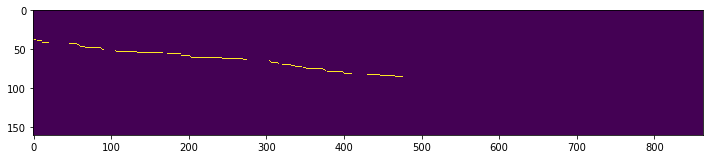

In [19]:
plt.figure(figsize = (12, 6))
plt.imshow(alignments_[0][0, :, :].cpu())
plt.show()

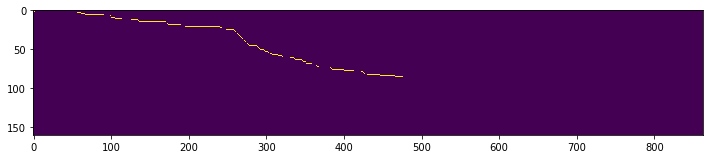

In [20]:
plt.figure(figsize = (12, 6))
plt.imshow(alignments[0][0, :, :].cpu())
plt.show()

In [25]:
alignments[0].cpu() == 

tensor([[[1, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])